# Importing a library that is not in Colaboratory

To import a library that's not in Colaboratory by default, you can use `!pip install` or `!apt-get install`.

In [1]:
# Refined Training Script for News Classification using DistilBERT

import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from accelerate import Accelerator
from torch.cuda.amp import autocast
from tqdm import tqdm

# Download NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_json('/content/drive/MyDrive/News_Category_Dataset_v3.json', lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [4]:
 #shape of the dataset
print(df.shape)
# total number of unique categories
print("Unique categories:",df['category'].nunique())
print("-------------------------------------------------")
# information about metadata
df.info()

(209527, 6)
Unique categories: 42
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [5]:
# general descrption of dataset
df.describe().style.set_properties(**{'background-color': '#F0F0F0',
                                    'color': '#222222',
                                    'border': '1.5px  solid black'})

,date
count,209527
mean,2015-04-30 00:44:14.344308736
min,2012-01-28 00:00:00
25%,2013-08-10 00:00:00
50%,2015-03-16 00:00:00
75%,2016-11-01 00:00:00
max,2022-09-23 00:00:00


In [6]:
new_df = df.drop(columns=['authors','link','date'])
new_df.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


<ipython-input-11-5dbf6ba8aa64>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=cat_df.head(10), x='news_classes', y='numcat', palette='Set2')


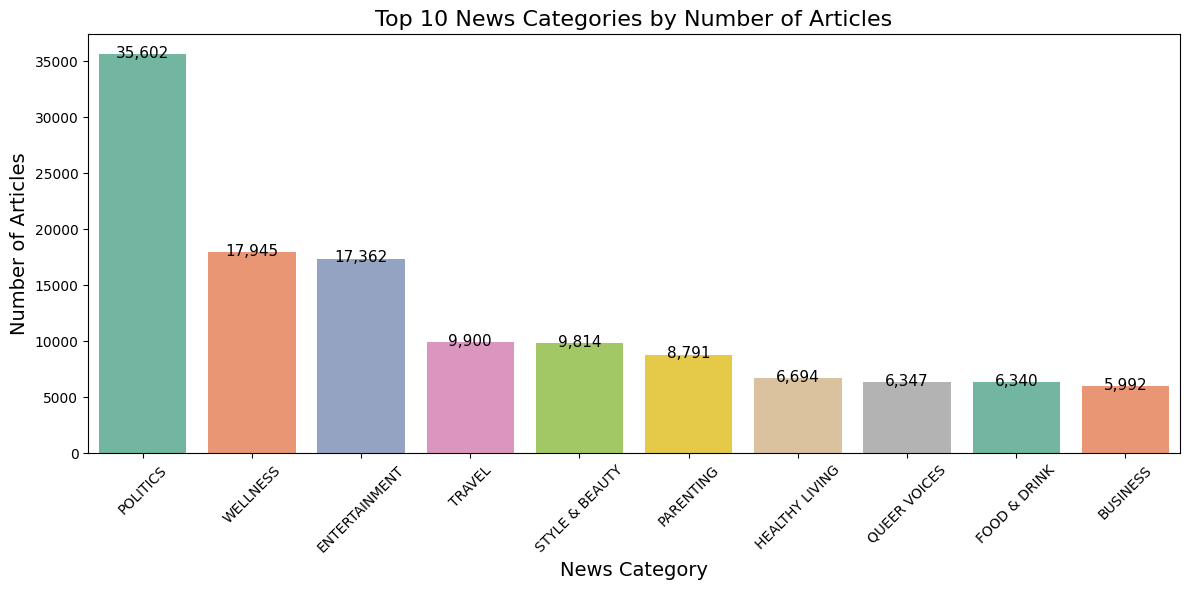

In [11]:
# Step 1: Count categories and convert to DataFrame
cat_df = pd.DataFrame(new_df['category'].value_counts().reset_index())
cat_df.columns = ['news_classes', 'numcat']

# Step 2: Plot Top 10 categories
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=cat_df.head(10), x='news_classes', y='numcat', palette='Set2')

# Step 3: Add value labels to bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height() + 100),
                ha='center', va='center', fontsize=11)

    plt.title("Top 10 News Categories by Number of Articles", fontsize=16)
plt.xlabel("News Category", fontsize=14)
plt.ylabel("Number of Articles", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


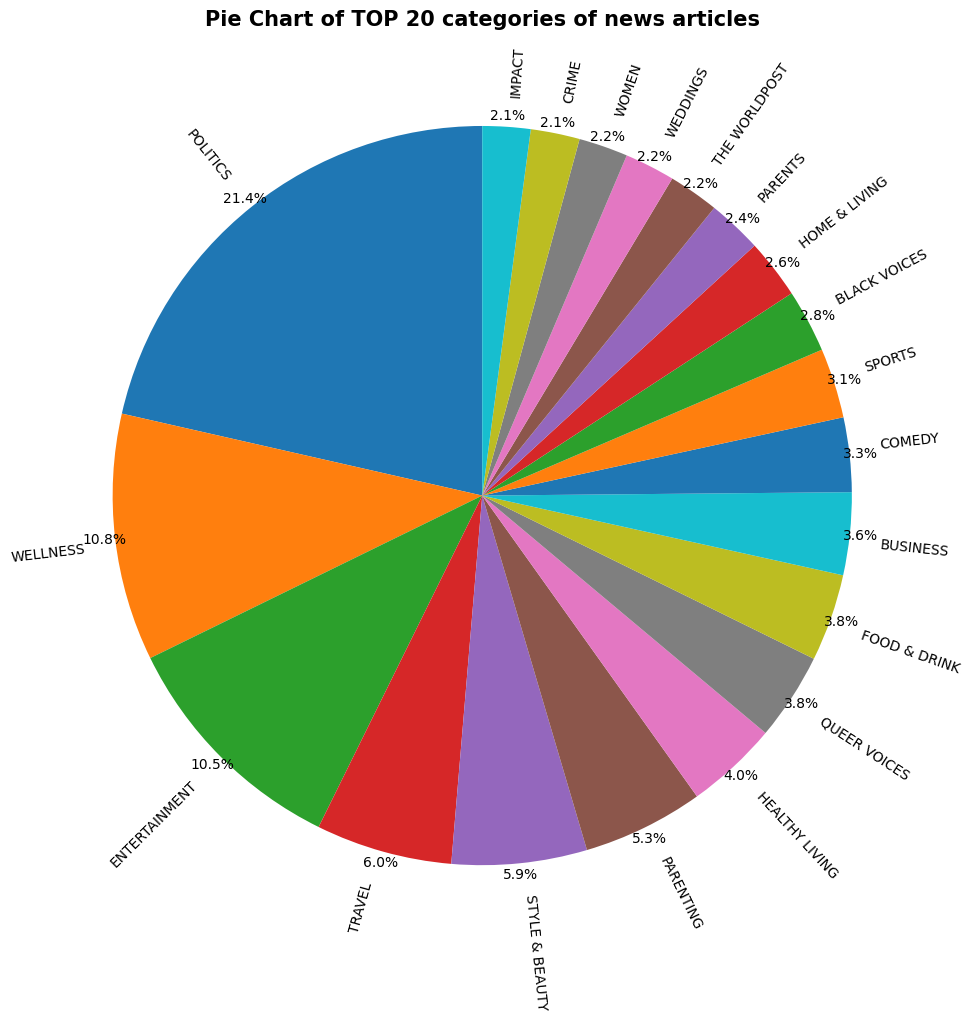

In [12]:
# plot the pie chart of top 20 categories of news articles
fig = plt.figure(figsize=(12,12))
A = plt.pie(cat_df['numcat'][:20],
            labels=cat_df['news_classes'][:20],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.08,
            pctdistance=1.03,
            rotatelabels=45
            )

plt.title("Pie Chart of TOP 20 categories of news articles", size=15, weight='bold')
plt.show()

In [13]:
# create final dataframe of combined headline and short_description
final_df = new_df.copy()
final_df['length_of_news'] = final_df['headline'] + final_df['short_description']
final_df.drop(['headline','short_description'], inplace=True, axis=1)
final_df['len_news'] = final_df['length_of_news'].map(lambda x: len(x))
final_df.head()

,category,length_of_news,len_news
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,230
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",248
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,133
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,215
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,233


In [14]:
# minimum lenght of news in each category
minlen_df = final_df.groupby('category')['len_news'].min().reset_index().sort_values(by='len_news',ascending=False)
minlen_df.head()

,category,len_news
35,U.S. NEWS,73
8,DIVORCE,66
33,THE WORLDPOST,56
36,WEDDINGS,54
21,MONEY,51


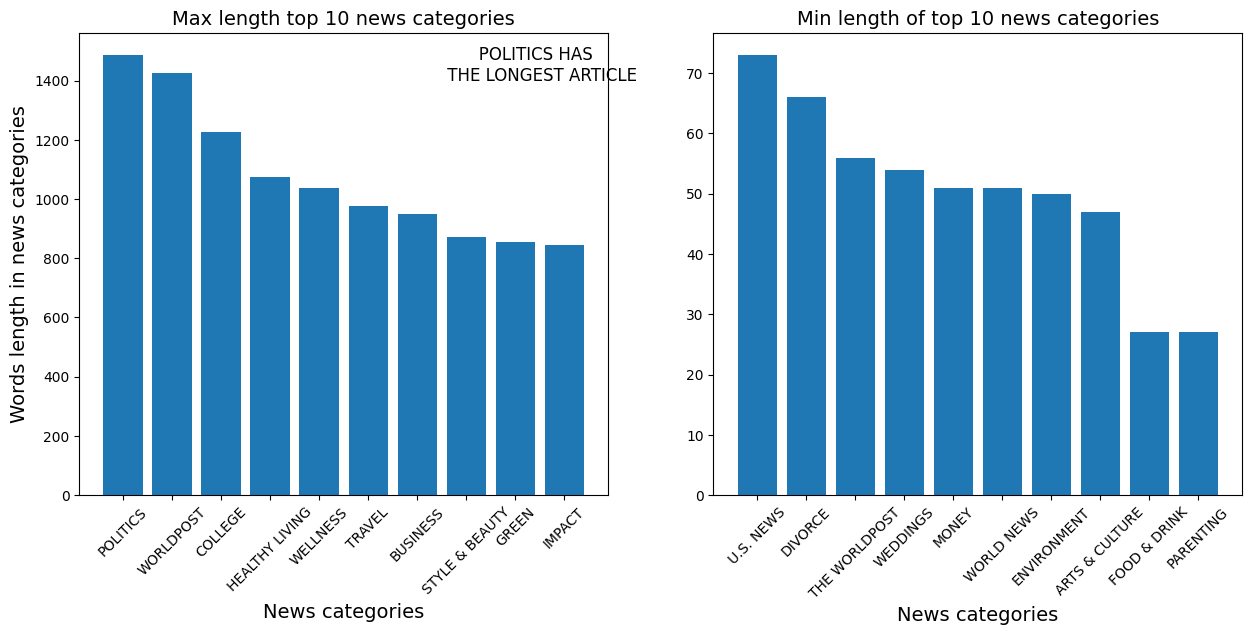

In [15]:
# plot the bar plots of max and min length of news articles

# Ensure the DataFrame is sorted correctly and uniquely per category
lenmax_df = final_df.sort_values(by='len_news', ascending=False).drop_duplicates('category').head(10)
lenmin_df = final_df.sort_values(by='len_news', ascending=True).drop_duplicates('category').head(10)

plt.figure(figsize=(15,6))

plt.subplot(121)
plt.bar(lenmax_df['category'][:10],lenmax_df['len_news'][:10])
plt.xticks(rotation=45)
plt.ylabel("Words length in news categories", size=14)
plt.xlabel("News categories",  size=14)
plt.text(6.5,1400, '''       POLITICS HAS
 THE LONGEST ARTICLE''', fontsize=12)
plt.title("Max length top 10 news categories", size=14)

plt.subplot(122)
plt.bar(minlen_df['category'][:10], minlen_df['len_news'][:10])
plt.xticks(rotation=45)
plt.xlabel("News categories", size=14)
plt.title("Min length of top 10 news categories", size=14)

plt.show()

In [17]:
# Clean text function
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    filtered = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(filtered)

# Load and preprocess dataset
df = pd.read_json('/content/drive/MyDrive/News_Category_Dataset_v3.json', lines=True)
df = df[['headline', 'category']].dropna()
df['clean_headline'] = df['headline'].apply(clean_text)

# Label encoding
le = LabelEncoder()
df['label'] = le.fit_transform(df['category'])

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    df['clean_headline'], df['label'], test_size=0.1, random_state=42, stratify=df['label'])

# Tokenizer and encoding
MAX_LEN = 128
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def encode_data(texts, labels):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt")
    return encodings, torch.tensor(labels.tolist())

train_encodings, train_labels = encode_data(X_train, y_train)
val_encodings, val_labels = encode_data(X_val, y_val)

class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

# Model
num_labels = len(le.classes_)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

# Freeze base layers initially
for param in model.distilbert.parameters():
    param.requires_grad = False

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

accelerator = Accelerator(mixed_precision="fp16")
model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

num_epochs = 10
best_val_loss = float('inf')
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=int(0.1 * num_training_steps), num_training_steps=num_training_steps)

# Training Loop
for epoch in range(num_epochs):
    # Unfreeze after 2 epochs
    if epoch == 2:
        for param in model.distilbert.parameters():
            param.requires_grad = True

    model.train()
    total_train_loss = 0
    loop = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for batch in loop:
        inputs, labels = batch
        with autocast():
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss

        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    # Validation
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    preds_list = []
    labels_list = []
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            with autocast():
                outputs = model(**inputs, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct / total
    print(f"\nValidation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(accelerator.unwrap_model(model).state_dict(), "best_model.pt")
        print("Best model saved.")

# Classification Report
print("\nClassification Report:")
print(classification_report(labels_list, preds_list, target_names=le.classes_))




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1:   0%|          | 0/5893 [00:00<?, ?it/s]<ipython-input-17-1e1c0a3dab4a>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training Epoch 1: 100%|██████████| 5893/5893 [01:27<00:00, 67.23it/s, loss=2.66]
<ipython-input-17-1e1c0a3dab4a>:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Validation Loss: 2.5147, Accuracy: 36.03%
Best model saved.


Training Epoch 2: 100%|██████████| 5893/5893 [01:29<00:00, 65.49it/s, loss=2.28]



Validation Loss: 2.1086, Accuracy: 43.91%
Best model saved.


Training Epoch 3: 100%|██████████| 5893/5893 [06:03<00:00, 16.23it/s, loss=1.11]



Validation Loss: 1.3512, Accuracy: 60.53%
Best model saved.


Training Epoch 4: 100%|██████████| 5893/5893 [06:01<00:00, 16.30it/s, loss=1.9]



Validation Loss: 1.2865, Accuracy: 62.28%
Best model saved.


Training Epoch 5: 100%|██████████| 5893/5893 [06:01<00:00, 16.30it/s, loss=0.657]



Validation Loss: 1.2935, Accuracy: 62.63%


Training Epoch 6: 100%|██████████| 5893/5893 [06:00<00:00, 16.33it/s, loss=1.1]



Validation Loss: 1.3431, Accuracy: 62.46%


Training Epoch 7: 100%|██████████| 5893/5893 [06:01<00:00, 16.32it/s, loss=0.815]



Validation Loss: 1.3972, Accuracy: 62.20%


Training Epoch 8: 100%|██████████| 5893/5893 [06:00<00:00, 16.33it/s, loss=0.587]



Validation Loss: 1.4436, Accuracy: 62.26%


Training Epoch 9: 100%|██████████| 5893/5893 [06:00<00:00, 16.34it/s, loss=0.39]



Validation Loss: 1.5011, Accuracy: 61.97%


Training Epoch 10: 100%|██████████| 5893/5893 [06:00<00:00, 16.34it/s, loss=0.82]



Validation Loss: 1.5338, Accuracy: 61.84%

Classification Report:
                precision    recall  f1-score   support

          ARTS       0.32      0.25      0.28       151
ARTS & CULTURE       0.36      0.29      0.32       134
  BLACK VOICES       0.56      0.51      0.53       458
      BUSINESS       0.52      0.53      0.52       599
       COLLEGE       0.50      0.49      0.49       114
        COMEDY       0.54      0.48      0.50       540
         CRIME       0.59      0.60      0.60       356
CULTURE & ARTS       0.55      0.24      0.34       107
       DIVORCE       0.78      0.74      0.76       343
     EDUCATION       0.49      0.37      0.42       101
 ENTERTAINMENT       0.70      0.73      0.72      1736
   ENVIRONMENT       0.56      0.34      0.42       144
         FIFTY       0.32      0.17      0.22       140
  FOOD & DRINK       0.66      0.73      0.69       634
     GOOD NEWS       0.34      0.34      0.34       140
         GREEN       0.36      0.43 